In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics


from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
# dummies
data = pd.read_csv('data/loan_2018_2020_final_dummies.csv',index_col=0) 
data.head()

,Charged Off,loan_amnt,installment,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,...,term_60,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,addr_state_NorEast,addr_state_South,addr_state_West,application_type_Joint App
0,0,14100.0,552.23,14.12,1.0,2005,0.0,12.0,0.0,62.6,...,0,0,1,0,0,1,0,1,0,0
1,1,20000.0,466.10,11.40,0.0,2002,0.0,12.0,0.0,46.2,...,1,0,0,1,0,0,1,0,0,0
2,0,7000.0,232.44,20.25,0.0,2007,0.0,13.0,0.0,36.0,...,0,0,0,0,0,0,0,1,0,0
3,0,21000.0,560.94,15.76,1.0,2008,0.0,15.0,0.0,34.2,...,1,0,1,0,0,0,1,0,0,0
4,0,40000.0,838.71,4.09,0.0,1996,0.0,6.0,1.0,9.4,...,1,0,0,0,0,1,1,0,0,0


In [4]:
# subset
#subset = data[:10000]  # 10k 
                        
#X = subset.iloc[:, 1:] # df                    # X = X.reshape(-1, 1)
#y = subset['Charged Off'] # Series


# all data

X = data.iloc[:, 1:] 
y = data['Charged Off']


print(X.shape)
print(y.shape)

(246004, 27)
(246004,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

## 3c. XGBoost

### 0. baseline

In [6]:
xgb_0 = XGBClassifier(eval_metric='mlogloss')
xgb_0.fit(X_train,y_train)
y_pred_xgb_0 = xgb_0.predict(X_test)

/Users/sabrina/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [8]:
print("Accuracy:  ",metrics.accuracy_score(y_test, y_pred_xgb_0 ))
print("Recall:    ",metrics.recall_score(y_test, y_pred_xgb_0 ))
print("F_1:       ",metrics.f1_score(y_test, y_pred_xgb_0 ))
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_0 , beta= 2))
print("F_beta3:   ",metrics.fbeta_score(y_test, y_pred_xgb_0 , beta= 3))
print("Precision: ",metrics.precision_score(y_test, y_pred_xgb_0))

Accuracy:   0.7980528851039613
Recall:     0.11556347086177897
F_1:        0.19035202086049544
F_beta2:    0.13711173197473764
F_beta3:    0.12541877845545915
Precision:  0.5394919168591225


Now that we've set a baseline (_F2 score looks sad tho_), let's turn to xgboost. Most of the parameters we'll use here :


- **n_estimators**: number of base learner trees  
- **max_depth**: max depth per base tree (typical values are 3-12)   
- **learning_rate**: shrinkage factor applied to each base tree update  
 
- **min_child_weight**: roughly the minimum allowable child samples for a tree split to occur  
- **subsample**: row subsampling rate (similar to RF)  
- **colsample_bytree**: feature subsampling rate (similar to RF) 

https://xgboost.readthedocs.io/en/latest/parameter.html#

## GridSerachCV  Tuning  

### 0. make Fbeta score for GridSreach by myself

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring

In [9]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV


ftwo_scorer = make_scorer(fbeta_score, beta=2)

### 1. scale_pos_weight
fix Classes Imbalance (i know my data is imbalance so I tuned this first)

In [10]:
# GridSearchCV
param_test1 = {"scale_pos_weight" : [1, 2, 3, 4, 5, 6]}     #range(1,6)}

gsearch1 = GridSearchCV(estimator=XGBClassifier(eval_metric='mlogloss'),
                        param_grid=param_test1, scoring = ftwo_scorer, cv=10)

gsearch1.fit(X_train,y_train)
#print(gsearch1.grid_scores_)
print(gsearch1.best_params_)
print("best F2 score:", gsearch1.best_score_)

/Users/sabrina/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'scale_pos_weight': 6}
best F2 score: 0.594046732347722


{'scale_pos_weight': 6}
best F2 score: 0.594046732347722

In [18]:
print(gsearch1.best_score_)  #scale_pos_weight = 6

0.5955609677692181


In [18]:
xgb_1 = XGBClassifier(eval_metric='mlogloss',scale_pos_weight = 5)  # 0.57866
xgb_1.fit(X_train,y_train)
y_pred_xgb_1 = xgb_1.predict(X_test)
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 2)) 

F_beta2:    0.5786693847294292


In [12]:
print("Accuracy:  ",metrics.accuracy_score(y_test, y_pred_xgb_1 ))
print("Recall:    ",metrics.recall_score(y_test, y_pred_xgb_1 ))
print("F_1:       ",metrics.f1_score(y_test, y_pred_xgb_1 ))
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 2))
#print("F_beta3:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 3))
print("Precision: ",metrics.precision_score(y_test, y_pred_xgb_1))

print("confusion matrix: \n\n", 
      confusion_matrix(y_test, y_pred_xgb_1))

Accuracy:   0.604825105180789
Recall:     0.7414663104778866
F_1:        0.4353053933954866
F_beta2:    0.5786693847294292
Precision:  0.3080907745436606
confusion matrix: 

 [[22264 16830]
 [ 2613  7494]]


In [14]:
xgb_1_2 = XGBClassifier(eval_metric='mlogloss',scale_pos_weight = 7) # 0.5974
xgb_1_2.fit(X_train,y_train)
y_pred_xgb_1_2 = xgb_1_2.predict(X_test)
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_1_2 , beta= 2))

F_beta2:    0.5974126961685282


In [16]:
xgb_1_3 = XGBClassifier(eval_metric='mlogloss',scale_pos_weight = 8) # 0.5991
xgb_1_3.fit(X_train,y_train)
y_pred_xgb_1_3 = xgb_1_3.predict(X_test)
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_1_3 , beta= 2))

F_beta2:    0.5991474147414743


In [ ]:
data["Charged Off"].value_counts(normalize=True)

- The class imbalance for original dataset is 0.79 (negative) vs 0.20(positive), so the most accurate scale_pos_weight should be around 4, but GridSearchCV shows me 5 worked out well so I choose 5 to continue my tunning. The reason I didn't choose anything above 6 (even their F2 score were higher) is because I don't want my classes got too many positive samples versus negative cases, and I assume the ideal ratio should be balance like 1: 1.

In [19]:
#multimetric_grid_search
#sorted(model.cv_results_.keys())

### 2. learning rate

- the use of a learning rate/shrinkage factor is a form of regularization that can greatly reduce overfitting. It typically trades off with the n_estimators and depth parameters (raising these add complexity) -- lower learning rate usually wants higher n_estimators, higher max depth usually wants lower learning rate etc.

In [10]:
param_test2 = {"learning_rate" : [0.01, 0.02, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}   #[round(x,2) for i in np.linspace(start = 0.01, stop = 0.6, num = 60)]}

                                               # n_estimators=100,n_jobs = -1,
gsearch2 = GridSearchCV(estimator=XGBClassifier(eval_metric='mlogloss', 
                                                scale_pos_weight= 5 ),
                        param_grid=param_test2, scoring = ftwo_scorer, cv=10)

gsearch2.fit(X_train,y_train)
print(gsearch2.best_params_)
print("best F2 score:", gsearch2.best_score_)

/Users/sabrina/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'learning_rate': 0.05}


In [ ]:
gsearch2.best_score_

{'learning_rate': 0.05}  , if scale_pos_weight=5

### 3. min_child_weight


- Minimum sum of instance weight(hessian) needed in a child. 
- default = 1

- The two subsampling parameters (_subsample and colsample_bytree_) and min_child_weight are also forms of regularization. These types of tradeoffs are part of why it typically works better to follow a **manual tuning** procedure than to try a massive grid search across different parameter combinations. That simply doesn't scale well to large datasets.

In [ ]:
# let's just do manual for this


# [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]

In [17]:
param_test3 =  {"min_child_weight" :range(1,102,2)}

                                            
gsearch3 = GridSearchCV(estimator=XGBClassifier(eval_metric='mlogloss', #n_estimators=71,
                                                scale_pos_weight= 5, 
                                                learning_rate = 0.05),
                        param_grid=param_test3, scoring = ftwo_scorer, cv=10)

gsearch3.fit(X_train,y_train)
print(gsearch3.best_params_)
print("best F2 score:", gsearch3.best_score_)

/Users/sabrina/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

- {"min_child_weight" :range(1,7)} -> {'min_child_weight': 6}
- {"min_child_weight" :range(1,10)} - > {'min_child_weight': 9}

- {"min_child_weight" :range(1,100,2)}  -> {'min_child_weight': 77}

### 4. max depth 
- usually we put : 3 to 12

In [ ]:
param_test4 =  {"max_depth" :range(3,14,2)}

                                            
gsearch4 = GridSearchCV(estimator=XGBClassifier(eval_metric='mlogloss', 
                                                scale_pos_weight= 5, 
                                                learning_rate = 0.05, 
                                                min_child_weight = 57), #
                        param_grid=param_test4, scoring = ftwo_scorer, cv=10)

gsearch4.fit(X_train,y_train)
print(gsearch4.best_params_)
print("best F2 score:", gsearch4.best_score_)

## TRY on model

In [19]:
xgb_2 = XGBClassifier(eval_metric='mlogloss',
                      scale_pos_weight = 5,
                      learning_rate = 0.05, 
                      min_child_weight = 57, 
                      max_depth = 5)   #
xgb_2.fit(X_train,y_train)
y_pred_xgb_2 = xgb_2.predict(X_test)

In [20]:
print("Accuracy:  ",metrics.accuracy_score(y_test, y_pred_xgb_2 ))
print("Recall:    ",metrics.recall_score(y_test, y_pred_xgb_2 ))
print("F_1:       ",metrics.f1_score(y_test, y_pred_xgb_2 ))
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_2 , beta= 2))
#print("F_beta3:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 3))
print("Precision: ",metrics.precision_score(y_test, y_pred_xgb_2))

print("confusion matrix: \n\n", 
      confusion_matrix(y_test, y_pred_xgb_2))

Accuracy:   0.5517164285278755
Recall:     0.7879687345404175
F_1:        0.41933445661331087
F_beta2:    0.5829734280067346
Precision:  0.2856835384008322
confusion matrix: 

 [[19181 19913]
 [ 2143  7964]]


### 5. n_estimators

- or just set it very big number and use "early stopping" to save time

- This way, we can set n_estimators to a very large number and simply train until we land at a good stopping point for validation error.

- (One technical problem with early stopping is that n_estimators selection can overfit to the validation data. One reasonable solution is to combine early stopping with k-fold cross validation, and use the average n_estimators across k training rounds for training a new model

In [ ]:
#param_test3 = {"n_estimators":range(1,301,10)}

                                           # n_estimators=100( default) 
#gsearch3 = GridSearchCV(estimator=XGBClassifier(eval_metric='mlogloss', scale_pos_weight= 5, learning_rate = 0.05),
                        #param_grid=param_test3, scoring = ftwo_scorer, cv=10)

#gsearch3.fit(X_train,y_train)
#print(gsearch3.best_params_)
#print("best F2 score:", gsearch3.best_score_)

In [23]:
xgb_3 = XGBClassifier(eval_metric='mlogloss',
                      scale_pos_weight = 5,
                      learning_rate = 0.05, 
                      min_child_weight = 57, 
                      max_depth = 5,
                      n_estimators = 300) 
xgb_3.fit(X_train,y_train)
y_pred_xgb_3 = xgb_3.predict(X_test)



In [24]:
print("Accuracy:  ",metrics.accuracy_score(y_test, y_pred_xgb_3 ))
print("Recall:    ",metrics.recall_score(y_test, y_pred_xgb_3 ))
print("F_1:       ",metrics.f1_score(y_test, y_pred_xgb_3 ))
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_3 , beta= 2))
#print("F_beta3:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 3))
print("Precision: ",metrics.precision_score(y_test, y_pred_xgb_3))

print("confusion matrix: \n\n", 
      confusion_matrix(y_test, y_pred_xgb_3))

Accuracy:   0.5866140932094877
Recall:     0.7666963490650045
F_1:        0.4324580740575384
F_beta2:    0.585643459596723
Precision:  0.3011659541391372
confusion matrix: 

 [[21113 17981]
 [ 2358  7749]]


# RUN THIS 

In [26]:
#   + n_jobs = -1, ,random_state =50,  

xgb_4 = XGBClassifier(eval_metric='mlogloss',
                      scale_pos_weight = 5,
                      learning_rate = 0.05, 
                      min_child_weight = 57, 
                      max_depth = 5 ,
                      n_estimators = 300,   
                      n_jobs = -1 ,random_state =50) 
xgb_4.fit(X_train,y_train)


y_pred_xgb_4 = xgb_4.predict(X_test)

In [29]:
print("Accuracy:  ",metrics.accuracy_score(y_test, y_pred_xgb_4 ))
print("Recall:    ",metrics.recall_score(y_test, y_pred_xgb_4 ))
print("F_1:       ",metrics.f1_score(y_test, y_pred_xgb_4 ))
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_4 , beta= 2))
#print("F_beta3:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 3))
print("Precision: ",metrics.precision_score(y_test, y_pred_xgb_4))

print("confusion matrix: \n\n", 
      confusion_matrix(y_test, y_pred_xgb_4))

Accuracy:   0.5866140932094877
Recall:     0.7666963490650045
F_1:        0.4324580740575384
F_beta2:    0.585643459596723
Precision:  0.3011659541391372
confusion matrix: 

 [[21113 17981]
 [ 2358  7749]]


# MUST RUN

Variable: term_60              Importance: 0.21960000693798065
Variable: home_ownership_RENT  Importance: 0.1859000027179718
Variable: inq_last_6mths       Importance: 0.06390000134706497
Variable: delinq_2yrs          Importance: 0.04540000110864639
Variable: revol_util           Importance: 0.04320000112056732
Variable: addr_state_West      Importance: 0.04320000112056732
Variable: installment          Importance: 0.04170000180602074
Variable: home_ownership_OWN   Importance: 0.041600000113248825
Variable: total_acc            Importance: 0.03150000050663948
Variable: log_annual_inc       Importance: 0.030899999663233757
Variable: loan_amnt            Importance: 0.026900000870227814
Variable: collections_12_mths_ex_med Importance: 0.02329999953508377
Variable: purpose_credit_card  Importance: 0.021299999207258224
Variable: dti                  Importance: 0.019899999722838402
Variable: log_revol_bal        Importance: 0.019500000402331352
Variable: earliest_cr_line     Importance: 0

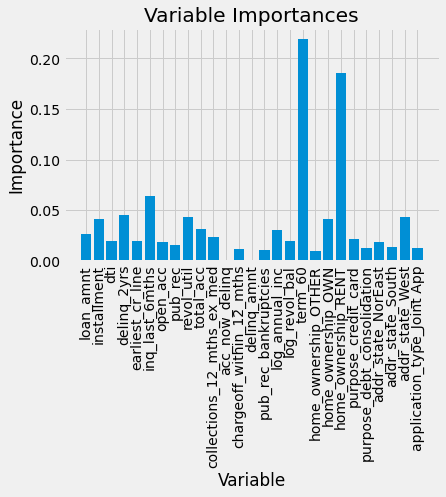

In [34]:
# feature importance   

feature_list = list(X_train.columns)
importances = list(xgb_4.feature_importances_)  # change model here
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

plt.style.use('fivethirtyeight')
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### 6.  early_stopping_rounds

Instead of trying to pick n_estimators by hand or do an intensive grid search, we'll use the early stopping technique as a massive time saver. This means that we track our validation error at each update step in the training process, and halt training once validation error hasn't improved in some number of early_stopping_rounds. This way, we can set n_estimators to a very large number and simply train until we land at a good stopping point for validation error.

In [ ]:
STOP HERE - 6 not working # future work

In [ ]:
# 6.1

xgb_6_1 = XGBClassifier( n_estimators=30000,
                       scale_pos_weight= 5, learning_rate = 0.05, 
                       min_child_weight =_________ , 
                       eval_metric='mlogloss')

xgb_6_1.fit(X_train,y_train, 
          early stopping = 50)

y_pred_xgb_6_1 = xgb_6_1.predict(X_test)

In [ ]:
# 6.2  (early stop 50 -> 30)


xgb_6_2 = XGBClassifier( n_estimators=30000,
                       scale_pos_weight= 5, learning_rate = 0.05, 
                       min_child_weight =_________ , 
                       eval_metric='mlogloss')
                      
xgb_6_2.fit(X_train,y_train, 
          early stopping = 30)

y_pred_xgb_6_2 = xgb_6_2.predict(X_test)

In [ ]:
print("Accuracy:  ",metrics.accuracy_score(y_test, y_pred_xgb_4 ))
print("Recall:    ",metrics.recall_score(y_test, y_pred_xgb_4 ))
print("F_1:       ",metrics.f1_score(y_test, y_pred_xgb_4 ))
print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_4 , beta= 2))
#print("F_beta3:   ",metrics.fbeta_score(y_test, y_pred_xgb_1 , beta= 3))
print("Precision: ",metrics.precision_score(y_test, y_pred_xgb_4))

print("confusion matrix: \n\n", 
      confusion_matrix(y_test, y_pred_xgb_4))

In [ ]:




gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

###  7.  subsample & colsample_by tree

subsample: row subsampling rate (similar to RF)
colsample_bytree: feature subsampling rate (similar to RF)

In [ ]:

# tune it if i have time


xgb_5 = XGBClassifier(eval_metric='mlogloss',
                      scale_pos_weight = 5,
                      learning_rate = 0.05, 
                      min_child_weight = 57, 
                      max_depth = 5 ,
                      n_estimators = 300,   
                      n_jobs = -1 ,random_state =50,
                     subsample = 0.5) 
xgb_5.fit(X_train,y_train)


y_pred_xgb_5 = xgb_5.predict(X_test)

print("F_beta2:   ",metrics.fbeta_score(y_test, y_pred_xgb_5 , beta= 2))

/Users/sabrina/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# Secret Recipe

#### 10k data
- {'scale_pos_weight': 5}
- {'learning_rate': 0.02}
- {'n_estimators': 71}
- {'min_child_weight': 3}

scale_pos_weight= 5, learning_rate = 0.05, 
                       min_child_weight =_________ , 
                       n_jobs = -1, ,random_state =50, eval_metric='m
                       
#### 100k data

#### MUST tune
learning rate,  early stopping 
XGB tune - Brian  (exercise: follow recipe!) notebook





In [ ]:
# TA: can i save this recipe one by one and run itself? 

# can save in dict  # but still not good - hypermeters interaction exist in XGB

# SHOW TIME! check if Fin Pro helps

- compare our current best model score with and without Fin Pro features


In [11]:
# fin pro df
#data = pd.read_csv('data/loan_2018_2020_final_dummies.csv',index_col=0) 
#data.head()

df_fin_pro = pd.read_csv('data/loan_2018_2020_FinPro.csv',index_col=0) 
df_fin_pro.head()

,int_rate,sub_grade,fico_score,last_fico_score
0,23.87,E2,662.0,717.0
1,14.07,C3,692.0,542.0
2,11.98,B5,697.0,707.0
3,20.39,D4,667.0,592.0
4,9.43,B1,732.0,777.0


In [9]:
df_fin_pro.columns

Index(['int_rate', 'sub_grade', 'fico_score', 'last_fico_score'], dtype='object')

In [12]:
fin_dummies = pd.get_dummies(df_fin_pro, columns=['sub_grade'], drop_first=True)
fin_dummies.head()

,int_rate,fico_score,last_fico_score,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,...,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5
0,23.87,662.0,717.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,14.07,692.0,542.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.98,697.0,707.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20.39,667.0,592.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.43,732.0,777.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
all_data = data.merge(fin_dummies, left_index=True, right_index=True)

In [ ]:
X1 = all_data.iloc[:, 1:]                
y1 = all_data['Charged Off']

X_tr, X_te, y_tr, y_te = train_test_split(X1, y1, test_size = 0.2, random_state = 10)


In [ ]:
best_model = 


